In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

# Preprocessing and Data Augmentation

In [4]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing

In [5]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 20
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    #model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    model = conv2DNet_9(Noutputs)
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output.view(bsize_eff), train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size, criterion)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
Epoch Number :  0
	 Training accuracy:  65.66666666666667
	 Validation accuracy  50.625
	 Test accuracy  67.5
	 Epoch Loss  100.9649887084961
Epoch Number :  1
	 Training accuracy:  77.76666666666667
	 Validation accuracy  72.5
	 Test accuracy  75.0
	 Epoch Loss  91.57951354980469
Epoch Number :  2
	 Training accuracy:  86.03333333333333
	 Validation accuracy  76.875
	 Test accuracy  78.1
	 Epoch Loss  75.56255340576172
Epoch Number :  3
	 Training accuracy:  87.56666666666666
	 Validation accuracy  81.875
	 Test accuracy  82.4
	 Epoch Loss  66.50798034667969
Epoch Number :  4
	 Training accuracy:  88.96666666666667
	 Validation accuracy  87.5
	 Test accuracy  77.5
	 Epoch Loss  60.92335891723633
Epoch Number :  5
	 Training accuracy:  86.7
	 Validation accuracy  79.375
	 Test accuracy  81.7
	 Epoch Loss  59.614166259765625
Epoch Number :  6
	 Training accuracy:  93.0
	 Validation accuracy  81.25
	 Test accuracy  76.7
	 Epoch Loss  55.278587341308594
Epoch Number :  7
	 Tr

Epoch Number :  9
	 Training accuracy:  92.43333333333334
	 Validation accuracy  77.5
	 Test accuracy  78.5
	 Epoch Loss  41.5676383972168
Epoch Number :  10
	 Training accuracy:  89.56666666666666
	 Validation accuracy  72.5
	 Test accuracy  75.6
	 Epoch Loss  43.278926849365234
Epoch Number :  11
	 Training accuracy:  97.03333333333333
	 Validation accuracy  77.5
	 Test accuracy  76.5
	 Epoch Loss  39.66020202636719
Epoch Number :  12
	 Training accuracy:  92.5
	 Validation accuracy  74.375
	 Test accuracy  77.5
	 Epoch Loss  39.46819305419922
Epoch Number :  13
	 Training accuracy:  96.8
	 Validation accuracy  79.375
	 Test accuracy  76.5
	 Epoch Loss  40.445858001708984
Epoch Number :  14
	 Training accuracy:  96.93333333333334
	 Validation accuracy  78.125
	 Test accuracy  80.4
	 Epoch Loss  35.2777214050293
Epoch Number :  15
	 Training accuracy:  96.76666666666667
	 Validation accuracy  74.375
	 Test accuracy  80.0
	 Epoch Loss  34.98060607910156
Epoch Number :  16
	 Training ac

Epoch Number :  19
	 Training accuracy:  96.63333333333334
	 Validation accuracy  75.0
	 Test accuracy  79.3
	 Epoch Loss  32.11739730834961
Epoch Number :  20
	 Training accuracy:  97.5
	 Validation accuracy  81.875
	 Test accuracy  79.6
	 Epoch Loss  31.0920467376709
Epoch Number :  21
	 Training accuracy:  97.03333333333333
	 Validation accuracy  73.125
	 Test accuracy  79.8
	 Epoch Loss  32.29684066772461
Epoch Number :  22
	 Training accuracy:  97.6
	 Validation accuracy  81.875
	 Test accuracy  80.6
	 Epoch Loss  33.852630615234375
Epoch Number :  23
	 Training accuracy:  97.6
	 Validation accuracy  83.125
	 Test accuracy  78.9
	 Epoch Loss  31.331466674804688
Epoch Number :  24
	 Training accuracy:  96.83333333333333
	 Validation accuracy  77.5
	 Test accuracy  79.5
	 Epoch Loss  30.91373062133789
Epoch Number :  25
	 Training accuracy:  96.73333333333333
	 Validation accuracy  75.0
	 Test accuracy  80.8
	 Epoch Loss  30.359594345092773
Epoch Number :  26
	 Training accuracy:  9

Epoch Number :  29
	 Training accuracy:  95.4
	 Validation accuracy  70.0
	 Test accuracy  78.5
	 Epoch Loss  32.71986770629883
Epoch Number :  30
	 Training accuracy:  96.46666666666667
	 Validation accuracy  75.625
	 Test accuracy  80.9
	 Epoch Loss  33.15837478637695
Epoch Number :  31
	 Training accuracy:  93.7
	 Validation accuracy  76.875
	 Test accuracy  76.7
	 Epoch Loss  30.69131088256836
Epoch Number :  32
	 Training accuracy:  94.46666666666667
	 Validation accuracy  76.25
	 Test accuracy  77.3
	 Epoch Loss  32.090824127197266
Epoch Number :  33
	 Training accuracy:  91.46666666666667
	 Validation accuracy  69.375
	 Test accuracy  79.3
	 Epoch Loss  31.67781639099121
Epoch Number :  34
	 Training accuracy:  94.23333333333333
	 Validation accuracy  70.0
	 Test accuracy  77.9
	 Epoch Loss  29.646724700927734
Epoch Number :  35
	 Training accuracy:  96.4
	 Validation accuracy  76.875
	 Test accuracy  79.0
	 Epoch Loss  31.809720993041992
Epoch Number :  36
	 Training accuracy: 

Epoch Number :  39
	 Training accuracy:  98.46666666666667
	 Validation accuracy  82.5
	 Test accuracy  76.5
	 Epoch Loss  28.15036392211914
Epoch Number :  40
	 Training accuracy:  97.4
	 Validation accuracy  77.5
	 Test accuracy  81.5
	 Epoch Loss  28.690000534057617
Epoch Number :  41
	 Training accuracy:  92.03333333333333
	 Validation accuracy  71.25
	 Test accuracy  80.7
	 Epoch Loss  28.965679168701172
Epoch Number :  42
	 Training accuracy:  97.86666666666666
	 Validation accuracy  81.25
	 Test accuracy  80.4
	 Epoch Loss  39.613189697265625
Epoch Number :  43
	 Training accuracy:  98.5
	 Validation accuracy  80.0
	 Test accuracy  77.0
	 Epoch Loss  29.8518009185791
Epoch Number :  44
	 Training accuracy:  98.43333333333334
	 Validation accuracy  81.25
	 Test accuracy  78.8
	 Epoch Loss  30.10174560546875
Epoch Number :  45
	 Training accuracy:  98.13333333333334
	 Validation accuracy  81.875
	 Test accuracy  78.3
	 Epoch Loss  30.5235652923584
Epoch Number :  46
	 Training acc

Epoch Number :  49
	 Training accuracy:  97.96666666666667
	 Validation accuracy  78.125
	 Test accuracy  82.3
	 Epoch Loss  30.155399322509766
Repetition 6
Epoch Number :  0
	 Training accuracy:  61.86666666666667
	 Validation accuracy  43.75
	 Test accuracy  49.8
	 Epoch Loss  103.36439514160156
Epoch Number :  1
	 Training accuracy:  70.2
	 Validation accuracy  43.75
	 Test accuracy  55.3
	 Epoch Loss  98.24874114990234
Epoch Number :  2
	 Training accuracy:  74.9
	 Validation accuracy  37.5
	 Test accuracy  54.6
	 Epoch Loss  92.25736236572266
Epoch Number :  3
	 Training accuracy:  80.53333333333333
	 Validation accuracy  51.25
	 Test accuracy  62.5
	 Epoch Loss  85.28690338134766
Epoch Number :  4
	 Training accuracy:  84.53333333333333
	 Validation accuracy  67.5
	 Test accuracy  74.1
	 Epoch Loss  74.12810516357422
Epoch Number :  5
	 Training accuracy:  87.16666666666667
	 Validation accuracy  64.375
	 Test accuracy  73.5
	 Epoch Loss  67.28700256347656
Epoch Number :  6
	 Tra

Epoch Number :  9
	 Training accuracy:  93.9
	 Validation accuracy  77.5
	 Test accuracy  75.5
	 Epoch Loss  46.11955261230469
Epoch Number :  10
	 Training accuracy:  93.7
	 Validation accuracy  74.375
	 Test accuracy  77.5
	 Epoch Loss  44.926048278808594
Epoch Number :  11
	 Training accuracy:  96.1
	 Validation accuracy  80.0
	 Test accuracy  78.5
	 Epoch Loss  41.34855651855469
Epoch Number :  12
	 Training accuracy:  96.63333333333334
	 Validation accuracy  73.75
	 Test accuracy  75.3
	 Epoch Loss  39.061771392822266
Epoch Number :  13
	 Training accuracy:  94.46666666666667
	 Validation accuracy  68.75
	 Test accuracy  77.3
	 Epoch Loss  39.0533332824707
Epoch Number :  14
	 Training accuracy:  97.13333333333334
	 Validation accuracy  80.0
	 Test accuracy  76.5
	 Epoch Loss  39.65049743652344
Epoch Number :  15
	 Training accuracy:  97.3
	 Validation accuracy  77.5
	 Test accuracy  74.9
	 Epoch Loss  38.33347702026367
Epoch Number :  16
	 Training accuracy:  96.06666666666666
	 

Epoch Number :  18
	 Training accuracy:  95.4
	 Validation accuracy  81.25
	 Test accuracy  76.6
	 Epoch Loss  35.33013916015625
Epoch Number :  19
	 Training accuracy:  96.96666666666667
	 Validation accuracy  81.25
	 Test accuracy  77.1
	 Epoch Loss  34.983055114746094
Epoch Number :  20
	 Training accuracy:  95.36666666666666
	 Validation accuracy  78.75
	 Test accuracy  75.8
	 Epoch Loss  33.70463180541992
Epoch Number :  21
	 Training accuracy:  96.0
	 Validation accuracy  78.75
	 Test accuracy  77.5
	 Epoch Loss  35.932762145996094
Epoch Number :  22
	 Training accuracy:  97.4
	 Validation accuracy  78.75
	 Test accuracy  76.9
	 Epoch Loss  30.853221893310547
Epoch Number :  23
	 Training accuracy:  94.1
	 Validation accuracy  83.125
	 Test accuracy  74.5
	 Epoch Loss  35.113399505615234
Epoch Number :  24
	 Training accuracy:  97.7
	 Validation accuracy  81.875
	 Test accuracy  77.4
	 Epoch Loss  33.82063293457031
Epoch Number :  25
	 Training accuracy:  97.56666666666666
	 Vali

Epoch Number :  28
	 Training accuracy:  96.76666666666667
	 Validation accuracy  78.75
	 Test accuracy  81.5
	 Epoch Loss  30.324190139770508
Epoch Number :  29
	 Training accuracy:  97.13333333333334
	 Validation accuracy  72.5
	 Test accuracy  80.8
	 Epoch Loss  29.75131607055664
Epoch Number :  30
	 Training accuracy:  97.03333333333333
	 Validation accuracy  72.5
	 Test accuracy  80.4
	 Epoch Loss  31.419233322143555
Epoch Number :  31
	 Training accuracy:  96.9
	 Validation accuracy  75.0
	 Test accuracy  80.4
	 Epoch Loss  34.712371826171875
Epoch Number :  32
	 Training accuracy:  97.3
	 Validation accuracy  72.5
	 Test accuracy  82.9
	 Epoch Loss  30.129634857177734
Epoch Number :  33
	 Training accuracy:  96.5
	 Validation accuracy  73.75
	 Test accuracy  78.5
	 Epoch Loss  29.57935333251953
Epoch Number :  34
	 Training accuracy:  97.56666666666666
	 Validation accuracy  70.0
	 Test accuracy  81.1
	 Epoch Loss  29.66017723083496
Epoch Number :  35
	 Training accuracy:  90.93

torch.Size([10, 50])
0


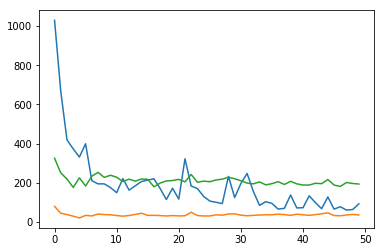

1


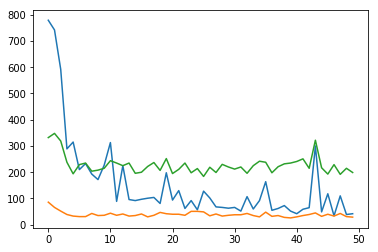

2


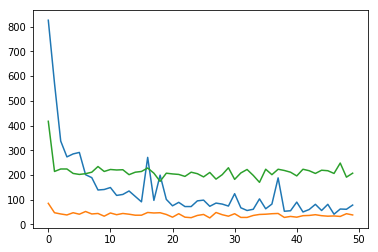

3


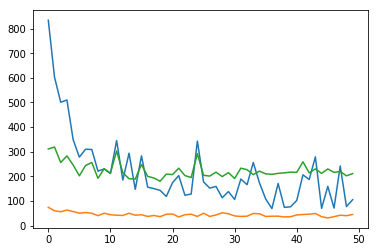

4


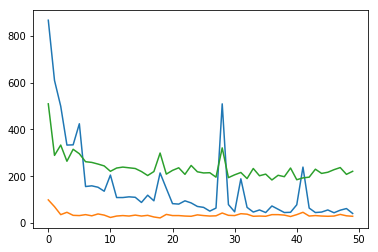

5


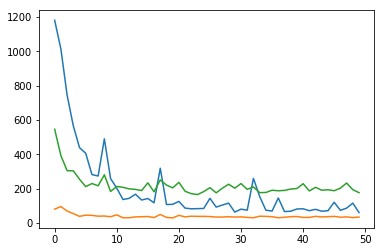

6


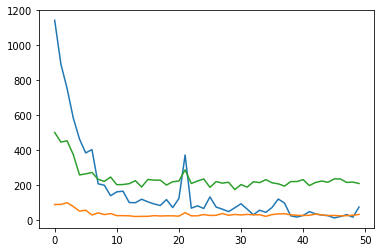

7


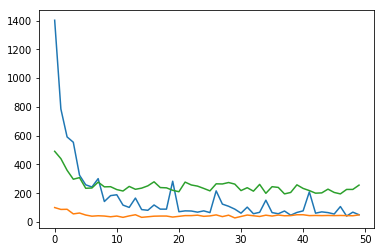

8


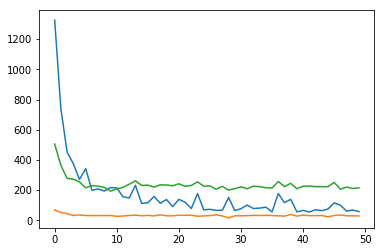

9


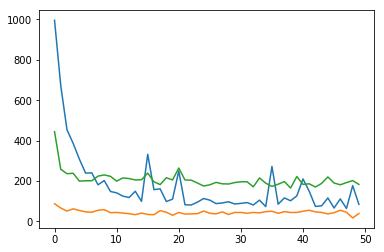

In [6]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


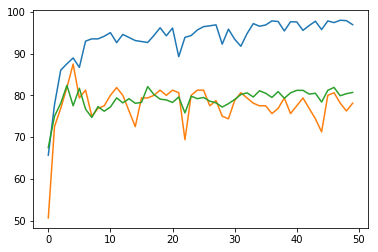

1


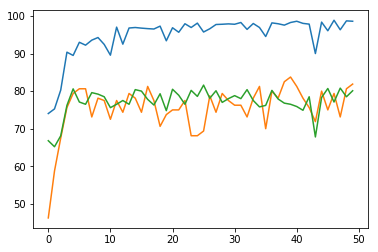

2


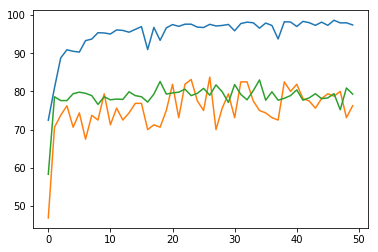

3


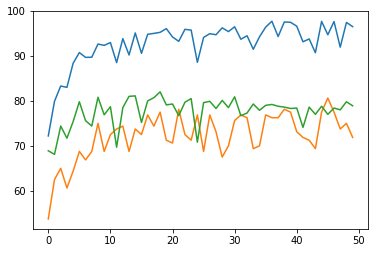

4


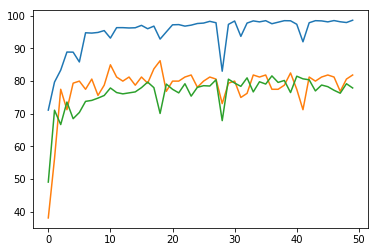

5


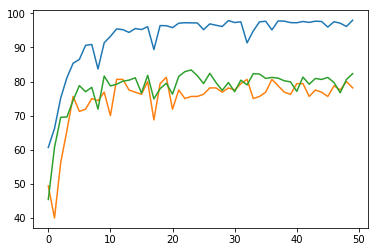

6


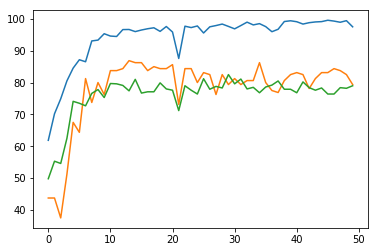

7


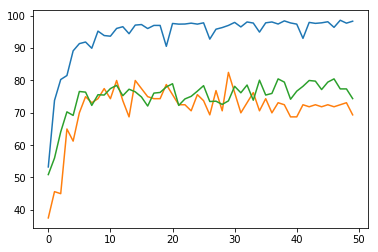

8


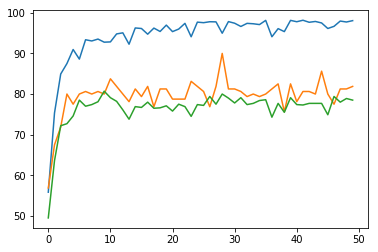

9


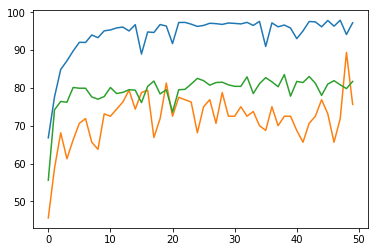

In [7]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(50,)
Training accuracy 97.7%+-0.6851112842559814
Validation accuracy 77.4%+-4.054800510406494
Testing accuracy 79.3%+-2.10275936126709


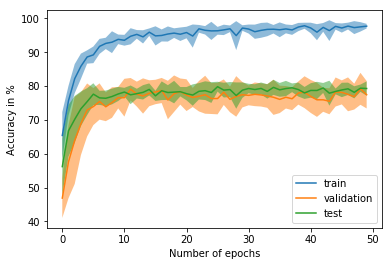

In [8]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))